# Final Project: Apollo 13 Free-Return

Our simulation is based from the 1970 spaceflight mission, Apollo 13, the seventh manned spaceflight in the Apollo program meant to land on the Moon. The craft was launched from the Kennedy Space Center in April 11 but two days into the mission there was a malfunction to the service module caused by an explosion, rupturing oxygen tank 2 which the three power cells were charged by. With oxygen leaking rapidly and the lunar landing cancelled, mission control in Houston had to devise a plan to calculate a ‘free return’ trajectory successfully landing the module in the South Pacific. Our simulation models this maneuver, not considering the orbit of the moon and solar winds.


<img src="https://www.nasa.gov/sites/default/files/thumbnails/image/15012354977_8fa070721a_o.jpg" alt="drawing" width="200"/>
<img src="https://www.nasa.gov/sites/default/files/images/112671main_image_feature_305_jwfull.jpg" alt="drawing" width="200"/>

In [ ]:
# Important math functions and the constant pi:
from math import sin, cos, atan2, sqrt, pi


# Use numpy library for dealing with arrays of floats:
import numpy as np


# Today we are adding Pandas for data presentation:
import pandas as pd

# The following import statement makes the plotting library available to us. There is also a mysterious
# statement beginning with % to work around a known Jupyter bug: https://github.com/jupyter/notebook/issues/3670
%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
# Use unit testing framework to test each function we write:
import unittest

## Constants

In [2]:
# The following two parameters are get us the strength of gravity at various heights:
g_e = 35.32 # 35.32 km/min**2 at Earth surface
g_m = 5.832 # km/min**2

radius_of_earth = 6371.0 # Earth radius in km
radius_of_moon =  1737.1 #km
distance_from_earth_to_moon = 384400 #km 


initial_radius = radius_of_earth + 500.0
initial_angle = 54.70
initial_speed = 672.0                   # km/min maintains the 500 km high orbit
moon_center = np.array([distance_from_earth_to_moon , 0.0])
# Properties of burns


burns_2 = [(1560.0, 42.0)]
burn_strength_2 = 4.0
# The following two parameters establish the simulation time step and its maximum total duration:
delta_t = 0.05                # simulation time step in minutes --- 0.05 is every three seconds
# For one burn resulting in an elliptical orbit, 5600 is a good value (that is 280 minutes)
simulation_time_steps = 161900  # For two-burn transfer orbit, change this to 9600 for 480 minutes (that is 8 hours)

# rocket mass
rocket_mass = 118000 # Mercury-Redstone launch mass in kg

# Because we are working in kilometers and minutes, if we want energy in Joules, we need to convert
meters_per_kilometer = 1000.0 # needed for conversion to Joules -- two lines below
seconds_per_minute = 60.0 # needed for conversion to Joules -- one line below
conversion_to_joules = (meters_per_kilometer / seconds_per_minute)**2


## Functions for Working with Vectors



In [3]:

def vector_from_length_and_angle(length: float, angle: float) -> np.ndarray:
    
    angle_in_radians = angle * pi / 180.0
    x_component = length * cos(angle_in_radians)
    y_component = length * sin(angle_in_radians)
    return np.array([x_component, y_component])


def angle_from_vector(vector: np.ndarray) -> float:
    
    angle_in_radians = atan2(vector[1], vector[0])  
   
    angle = angle_in_radians * 180.0 / pi
    
    return angle


def length_from_vector(vector: np.ndarray) -> float:
    length_squared = np.sum(vector**2)
    return sqrt(length_squared)

initial_position = vector_from_length_and_angle(initial_radius, initial_angle + 90.0) 
initial_velocity = vector_from_length_and_angle(initial_speed, initial_angle)

## Functions to Get Acceleration due to Gravity



In [4]:

def strength_of_gravity_earth(position: np.ndarray) -> float:
    radius = (length_from_vector(position)) 
    strength_earth = ((g_e *radius_of_earth**2 )/ radius**2)
    return strength_earth

def strength_of_gravity_moon(position: np.ndarray) -> float:
    delta_position = np.subtract(position,moon_center)
    radius_from_moon = (length_from_vector(delta_position)) 
    strength_moon = ((g_m * radius_of_moon**2) / radius_from_moon**2)
    return strength_moon

def direction_of_gravity_earth(position: np.ndarray) -> np.ndarray:
    direction_earth = angle_from_vector(position) + 180.0
    return direction_earth

def direction_of_gravity_moon(position: np.ndarray) -> np.ndarray:
    delta_position = np.subtract(position,moon_center)
    direction_moon = angle_from_vector(delta_position) + 180.0 
    return direction_moon


def acceleration_from_gravity(position: np.ndarray) -> np.ndarray:
    
    strength_earth = strength_of_gravity_earth(position)
    direction_earth = direction_of_gravity_earth(position)
    strength_moon = strength_of_gravity_moon(position)
    direction_moon = direction_of_gravity_moon(position)
    acceleration_earth = vector_from_length_and_angle(strength_earth, direction_earth)
    acceleration_moon = vector_from_length_and_angle(strength_moon, direction_moon)
    
    acceleration = acceleration_earth + acceleration_moon
    return acceleration



## Functions to get Acceleration of Thrust for Correction Burn



In [5]:


#correction burn
def strength_of_thrust_2(time: float) -> float:
    
    for burn in burns_2:
        begin_time , burn_duration = burn
        if time > begin_time and time < begin_time + burn_duration : 
            return burn_strength_2 
  
    return 0.0

def direction_of_thrust_2(velocity: np.ndarray) -> np.ndarray:
    direction = angle_from_vector(velocity) + 180
    return direction

def acceleration_from_thrust_2(time: float, velocity: np.ndarray) -> np.ndarray:
    strength = strength_of_thrust_2(time)
    direction = direction_of_thrust_2(velocity)
    acceleration_2 = vector_from_length_and_angle(strength, direction)
    return acceleration_2



## The While Loop That Does the Work &mdash; 2nd Order Runge-Kutta



In [6]:
# Initialize the x and y velocities
velocities = np.zeros((simulation_time_steps, 2))
velocities[0] = initial_velocity

# Initialize the x and y positions
positions = np.zeros((simulation_time_steps, 2))
positions[0] = initial_position

# Initialize the times
times = np.zeros((simulation_time_steps,))

# The 0th elements of velocities, positions, and times are already filled in, so start with 1
for i in range(1, simulation_time_steps):
    #
    # get all the before values
    #
    # velocities
    before_velocity = velocities[i - 1]
    # positions
    before_position = positions[i - 1]
    # time
    before_time = times[i - 1]
    #
    # fundamental change for 2nd-order Runge-Kutta -- estimate mid_position
    #
    mid_position = before_position + 0.5 * delta_t * before_velocity
    #
    # need before_acceleration
    #
    before_acceleration = acceleration_from_gravity(before_position) + acceleration_from_thrust_2(before_time, before_velocity)
    #
    # now can get mid_velocity estimate
    #
    mid_velocity = before_velocity + 0.5 * delta_t * before_acceleration
    #
    # also compute mid_time
    #
    mid_time = before_time + 0.5 * delta_t
    #
    # Using mid_position, mid_velocity, and mid_time compute mid_acceleration
    #
    mid_acceleration = acceleration_from_gravity(mid_position)  +  acceleration_from_thrust_2(mid_time, mid_velocity)
    #
    # calculate after_velocity using mid_acceleration
    #
    after_velocity = before_velocity + delta_t * mid_acceleration
    #
    # calculate after_position using the democratic combination 
    # of (after_velocity + before_velocity) / 2
    #
    after_position = before_position + delta_t * (after_velocity + before_velocity) / 2.0
    #
    # update time
    #
    after_time = before_time + delta_t
    #
    # assign the after values into their lists
    #
    velocities[i] = after_velocity
    positions[i] = after_position
    times[i] = after_time
    
    

## Panda DataFrame

In [7]:
df = pd.DataFrame({
    'time' : times[:],
    'x_pos' : positions[:, 0],
    'y_pos' : positions[:, 1],
    'x_vel' : velocities[:, 0],
    'y_vel' : velocities[:, 1]
})

# radius
df['radius'] = (df.x_pos**2 + df.y_pos**2)**0.5
# use the radius to get the elevation
df['elevation'] = df.radius - radius_of_earth
# get the speed
df['speed'] = (df.x_vel**2 + df.y_vel**2)**0.5
# construct a unit vector
df['xs_pos'] = df.x_pos / df.radius
df['ys_pos'] = df.y_pos / df.radius
# dot the unit vector into the velocity to get the radial speed (rate of altitude change)
df['radial_speed'] = df.x_vel * df.xs_pos + df.y_vel * df.ys_pos



# Graph of Simulated Free-Return Trajectory

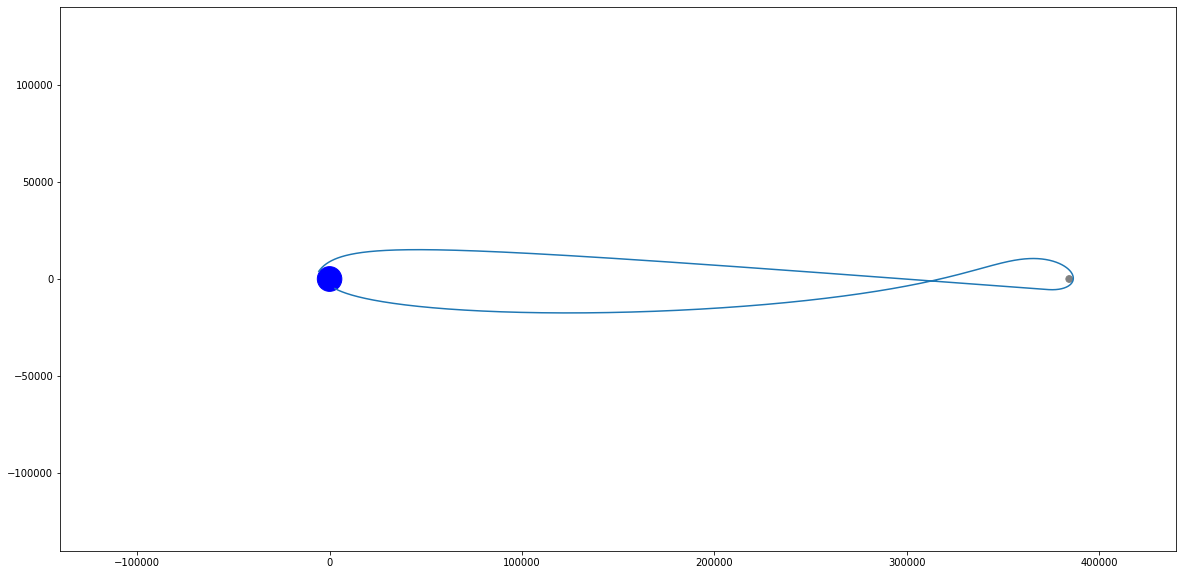

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_limit = 200000
plt.xlim(-0.7 * plot_limit,2.2 * plot_limit)
plt.ylim(-0.7 * plot_limit, 0.7 * plot_limit)

earth = plt.Circle((0, 0), radius_of_earth, color='blue')
plt.gcf().gca().add_artist(earth)

moon = plt.Circle((distance_from_earth_to_moon, 0), radius_of_moon, color='grey')
plt.gcf().gca().add_artist(moon)

line, = ax.plot(0,0)

def animate(position):
    line.set_xdata(df.x_pos)
    line.set_ydata(df.y_pos)
    return line,

ani = animation.FuncAnimation(fig, animate, interval=2)

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("freereturn.mp4", writer=writer)



plt.show()

# Real Apollo 13 Free-Return Trjectory
![alt text](https://www.researchgate.net/profile/Ralf_Boden/publication/319122341/figure/fig2/AS:631675100880944@1527614488564/Free-Return-trajectory-used-during-Apollo-13-shown-in-the-Earth-Moon-rotating-frame.png "Logo Title Text 1")

Text(0.5, 0, 'time (minutes)')

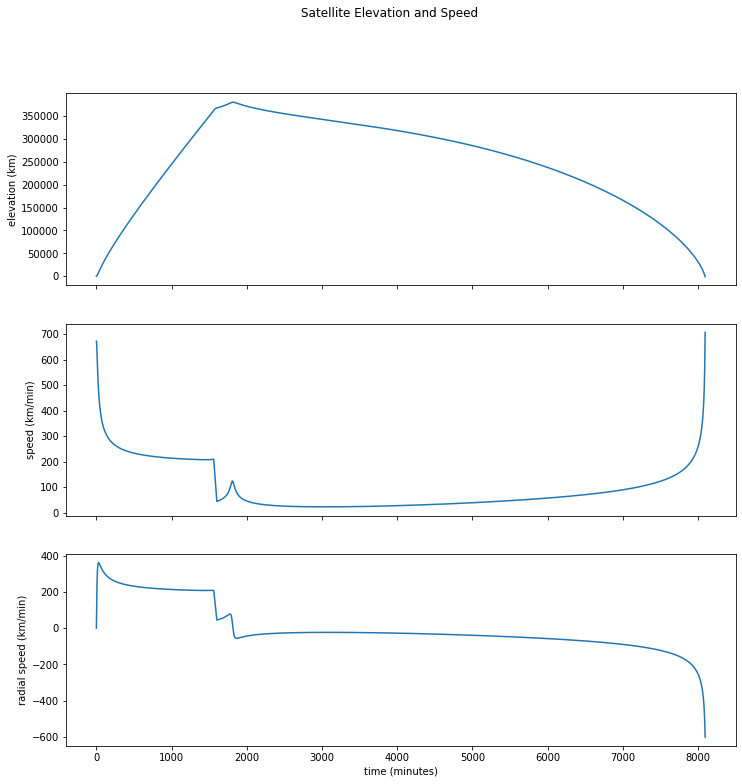

In [12]:
# Satellite Elevation and Speed

fig, axs = plt.subplots(3, figsize=(12, 12), sharex=True)
fig.suptitle('Satellite Elevation and Speed')

# first subplot
axs[0].set_ylabel('elevation (km)')
axs[0].plot(df.time, df.elevation)

# second subplot
axs[1].set_ylabel('speed (km/min)')
axs[1].plot(df.time, df.speed)

# third subplot
axs[2].set_ylabel('radial speed (km/min)')
axs[2].plot(df.time, df.radial_speed)

# Only set x label on the third subplot
axs[2].set_xlabel('time (minutes)')

